Conditional GaNN includes getting specific data output based on some input condition

This condition is passed to both generator and discriminator, it's passed to discriminator so as he could get what generator was supposed to do and judge generator accordingly. 
1. Condition is given and converted to embedding by both model's separately
2. Condition is given by same embedding to both models.


In [ ]:
import numpy as np 
from keras.datasets import cifar10
import matplotlib.pyplot as plt

In [ ]:
(trainX,trainY),(_,_) = cifar10.load_data()

170508288/170498071 [==============================] - 14s 0us/step


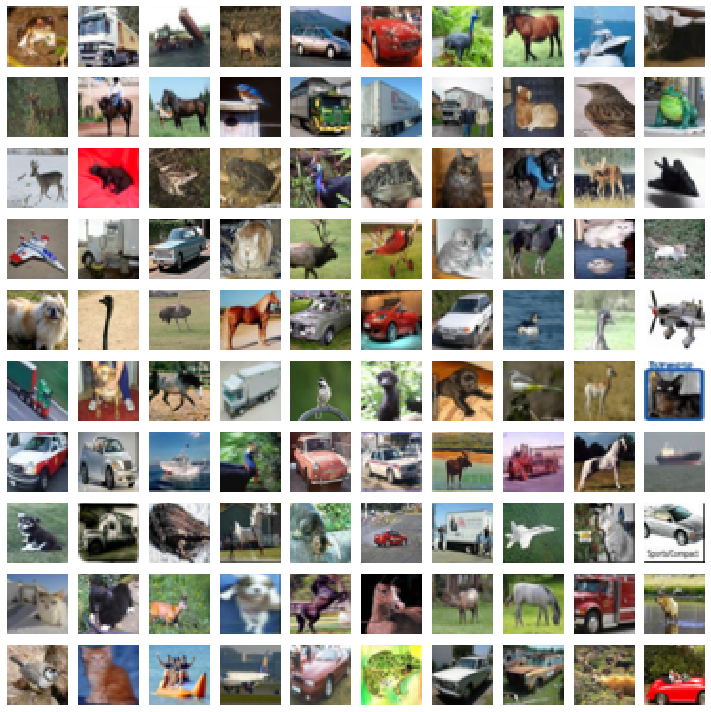

In [ ]:
plt.figure(figsize=(10,10))
for i in range(100): 
  plt.subplot(10,10,i+1)
  plt.imshow(trainX[i],interpolation='nearest'); 
  plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
print(trainY[0],trainY[1],trainY[2])  ## this is dataset of various catergories like cars, dogs,cats,birds houses etc. 
print(max(trainY),min(trainY)) ## it has 10 categories and we want our model to produce data based on give category 

[6] [9] [9]
[9] [0]


In [ ]:
### normalize our dataset 
trainX = (trainX.astype('float32') - 127.5)/127.5

In [ ]:
from keras.layers import Input,Conv2D,Conv2DTranspose,BatchNormalization,Embedding,Dense,Dropout,Reshape,Concatenate,Flatten

In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam_v2

In [ ]:
from keras.models import Model

In [ ]:
## defining some global variables 
adam = adam_v2.Adam(learning_rate=2e-4,beta_1=.5)
EPOCHS = 100
BATCH_SIZE = 512
MINI_BATCH = 256
NO_BATCHES = int(trainX.shape[0]/BATCH_SIZE)
NOISE = 100

In [ ]:
#### firstly creating discriminator that takes input image and category which needs to be converted to desired format
def createDiscriminator():
  in_category = Input((1,))
  embedding = Embedding(10,50)(in_category)     # embedding taking from 10 categories and representing as vector of size = 5
  embedding = Dense(32*32)(embedding)
  # embedding = LeakyReLU(.2)(embedding)
  embedding = Reshape((32,32,1))(embedding)

  in_image = Input(shape=(32,32,3))
  merge = Concatenate()([in_image,embedding])

  merge = Conv2D(64,(3,3),strides=(2,2),padding='same')(merge)
  merge = LeakyReLU(.2)(merge)

  merge = Conv2D(128,(3,3),strides=(2,2),padding='same')(merge)
  merge = LeakyReLU(.2)(merge)

  merge = Flatten()(merge)
  merge = Dropout(.4)(merge)  #### for regularization
  output = Dense(1,activation='sigmoid')(merge)

  discriminator = Model([in_image,in_category],output)
  discriminator.compile(loss='binary_crossentropy',optimizer=adam)
  discriminator.summary()
  return discriminator; 

In [ ]:
## creating generator takes input noise and lable as input then conbine them to generate image
## we are going to get 128*8*8 by dense layer from noise which is going to be upscaled to desired form of image 
def createGenerator(): 
  in_label = Input((1,))
  embedding = Embedding(10,50)(in_label)
  embedding = Dense(8*8)(embedding)
  # embedding = LeakyReLU(.2)(embedding)
  embedding = Reshape((8,8,1))(embedding)

  in_noise = Input((NOISE,))
  noise = Dense(8*8*32)(in_noise)
  noise = LeakyReLU(.2)(noise)
  noise = Reshape((8,8,32))(noise)

  merge = Concatenate()([noise,embedding])
  merge = Conv2DTranspose(64,kernel_size=(4,4),strides=(2,2),padding='same')(merge)
  merge = LeakyReLU(.2)(merge)

  merge = Conv2DTranspose(128,kernel_size=(4,4),strides=(2,2),padding='same')(merge)
  merge = LeakyReLU(.2)(merge)

  output = Conv2D(3,kernel_size=(8,8),padding='same',activation='tanh')(merge)
  generator = Model([in_noise,in_label],output)
  # generator.compile(loss='binary_crossentropy',optimizer=adam)
  generator.summary()
  return generator
# createGenerator()

In [ ]:
def generatorPipeline(generator,discriminator):
  discriminator.trainable = False
  gen_noise,gen_label = generator.input
  generatedImage = generator.output
  discriminatorOutput = discriminator([generatedImage,gen_label])
  pipeline = Model([gen_noise,gen_label],discriminatorOutput)
  pipeline.compile(loss='binary_crossentropy',optimizer=adam)
  pipeline.summary()
  return pipeline


In [ ]:
!mkdir 250images
!ls

250images  sample_data


In [ ]:
def saveFigure(epoch,generator):
  samples = 100
  plt.figure(figsize=(10,10))
  for i in range(samples):
    plt.subplot(10,10,i+1)
    noise = np.random.normal(0,1,(1,NOISE))
    generatedImage = generator.predict([noise,np.array([i%10]).reshape((1,1)) ])[0]
    generatedImage = (generatedImage + 1)/2
    plt.imshow(generatedImage,interpolation='nearest')
    plt.axis('off')
  plt.tight_layout()
  plt.savefig('250images/generatedInEpoch({0})'.format(epoch+1))
  plt.show()

In [ ]:
def train(generator,discriminator,generatorPipeline): 
  generator_losses = []
  discriminator_losses = []
  EPOCHS = 250
  for e in range(EPOCHS):
    d_loss = 0
    g_loss = 0
    for b in range(NO_BATCHES): 
      ## first step is to train generator 
      gb_loss = 0
      db_loss = 0
      ids = np.random.randint(0,trainX.shape[0],MINI_BATCH)
      realX = trainX[ids]
      realY = trainY[ids].reshape((-1,1))
      realOutput = np.ones((MINI_BATCH,1))*.9
      fakeLables = np.random.randint(1,10,(MINI_BATCH,1))
      noise = np.random.normal(0,1,(MINI_BATCH,NOISE))
      generatedImages = generator.predict([noise,fakeLables])
      fakeOutput = np.zeros((MINI_BATCH,1))
      discriminator.trainable = True
      db_loss += discriminator.train_on_batch([realX,realY],realOutput)
      db_loss += discriminator.train_on_batch([generatedImages,fakeLables],fakeOutput)
      db_loss/=2

      ## second step is to train generator 
      noise = np.random.normal(0,1,(BATCH_SIZE,NOISE))
      lables = np.random.randint(1,10,(BATCH_SIZE,1))
      realOutput = np.ones((BATCH_SIZE,1))
      # discriminator.trainable = False
      gb_loss += pipeline.train_on_batch([noise,lables],realOutput)
      if b%10 == 0 : 
        print("BATCH : %d generator Loss : %.5f Discriminator Loss %.5f"%(b,gb_loss,db_loss))
      d_loss += db_loss
      g_loss += gb_loss
    if e%10 == 0 : 
      print("#### EPOCH : %d generator Loss : %.5f Discriminator Loss %.5f ####"%(e,g_loss,d_loss))
      saveFigure(e,generator)
    generator_losses.append(g_loss)
    discriminator_losses.append(d_loss)
  xLables = np.arange(1,EPOCHS+1)
  plt.plot(xLables,generator_losses,'r')
  plt.plot(xLables,discriminator_losses,'b')
  plt.savefig("250images/loss_trend.jpg")
  plt.show()

In [ ]:
generator = createGenerator()
discriminator = createDiscriminator()
pipeline = generatorPipeline(generator,discriminator)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 2048)         206848      ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                              

In [ ]:
train(generator,discriminator,pipeline)

BATCH : 0 generator Loss : 0.87809 Discriminator Loss 0.64891
BATCH : 10 generator Loss : 0.98341 Discriminator Loss 0.63286
BATCH : 20 generator Loss : 0.90491 Discriminator Loss 0.67099


KeyboardInterrupt: ignored

In [ ]:
# !zip -r result.zip images
# from google.colab import files
# files.download('result.zip')